In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
from scipy.optimize import root_scalar

aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [6]:
%%time
scenario = "Anaheim" #"Berlin-Center" #
num_iters = 10
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1]


### Iterations
solutions_per_origin = {}
od_path_times = {}

for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t_assignment.compute_shortest_paths(origin)
    #print(f"  {datetime.now()} - dijsktra done")
    
    for origin in origins:
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        solutions_per_origin[origin] = solution

# t_assignment.update_path_flows(origin, solutions_per_origin[origin])

    for origin in origins:
        t_assignment.update_current_iteration_flows_by_origin(origin, solutions_per_origin[origin])
    print(f"  {datetime.now()} - update done")

    # not parallel:
    try:
        min_res = root_scalar(lambda x: t_assignment.objective_derivative_stepsize(x), bracket=[0, 1])
        stepsize = min_res.root
    except ValueError:
        left_ = t_assignment.objective_derivative_stepsize(0)
        right_ = t_assignment.objective_derivative_stepsize(1)
        print(f"     error finding stepsize: {left_:.0f}, {right_:.0f}")
        # need to decide what to do here
        if left_ < right_:
            stepsize = 0.01
        else:
            stepsize = 0.99
    print(f"  {datetime.now()} - Stepsize finding done: {stepsize}")
    
    # update solution:
    t_assignment.update_link_flows_stepsize(stepsize)
    print(f"  {datetime.now()} - Blending link flows done")


    # now this can be parallel again
    for origin in origins:
        # update path flows: new_path_flows = (1-stepsize) * old_path_flow + stepsize * new_path_flow
        t_assignment.update_path_flows_stepsize(origin, stepsize)
        # 
    print(f"  {datetime.now()} - blended path flows")


    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)

    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")

print(f"{datetime.now()} - Done")
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-06 22:24:47.492728 - Running scenario Anaheim
2020-12-06 22:24:47.534547 - num nodes = 416, num links = 914
2020-12-06 22:24:47.547021 - performing initial solution
  2020-12-06 22:24:47.569793 - starting iteration 0
  2020-12-06 22:24:47.895550 - update done
  2020-12-06 22:24:47.904352 - Stepsize finding done: 0.6041183570531465
  2020-12-06 22:24:47.905167 - Blending link flows done
  2020-12-06 22:24:47.905260 - blended path flows
  2020-12-06 22:24:47.916282 - computed path times and flows, computed gap: 0.012595640498146543, computed objective: 1214708.375
  2020-12-06 22:24:47.916554 - starting iteration 1
  2020-12-06 22:24:48.308347 - update done
  2020-12-06 22:24:48.313510 - Stepsize finding done: 0.18012016765817024
  2020-12-06 22:24:48.314438 - Blending link flows done
  2020-12-06 22:24:48.314531 - blended path flows
  2020-12-06 22:24:48.326929 - computed path times and flows, computed gap: 0.012346087237961045, computed objective: 1212894.125
  2020-12-06 22:24

In [7]:
%%time
compare_flows = True
if compare_flows:
    bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)

CPU times: user 12.5 s, sys: 281 ms, total: 12.8 s
Wall time: 5.65 s


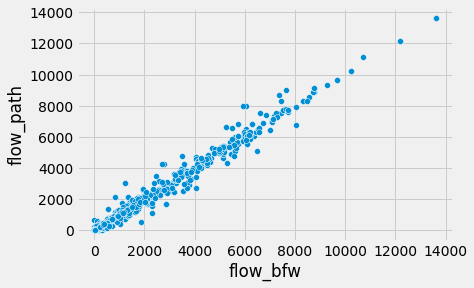

max diff in flow = 2041.038
max rel diff in flow = 540416156.697%


,link_id,a_node,b_node,ff_time,capacity,direction,flow_bfw,flow_path,abs_change,rel_change
423,423,269,25,0.149068,12600,1,5949.637996,7990.675781,2041.037785,0.343052
31,31,25,268,0.149068,12600,1,6041.763444,7951.925781,1910.162338,0.316160
131,131,83,261,0.500000,1800,1,1213.546166,3053.032227,1839.486060,1.515794
398,398,261,269,1.859848,5400,1,1213.546166,3053.032227,1839.486060,1.515794
412,412,266,265,1.000000,5400,1,2700.582315,4284.901855,1584.319541,0.586658
406,406,265,139,0.500000,1800,1,2766.082315,4292.510742,1526.428427,0.551838
214,214,140,139,0.272615,7200,1,6502.978147,5065.759766,1437.218382,0.221009
179,179,115,114,0.229038,7200,1,5240.774880,6653.873535,1413.098655,0.269635
178,178,114,113,0.316192,7200,1,5240.774880,6653.873535,1413.098655,0.269635
645,645,337,29,0.149068,12600,1,7646.594981,8988.798828,1342.203847,0.175530


CPU times: user 156 ms, sys: 109 ms, total: 266 ms
Wall time: 257 ms


In [8]:
%%time
compare_flows = True
if compare_flows:
    full_result = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
    sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
    plt.show();
    full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
    full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
    print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
    print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
    display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))

In [ ]:
# Cannot compare, best solution blocks flows through centroids. Agrees with BFW, so let's go with comparison to that
# #if scenario == "Anaheim":
# best_ = pd.read_csv(os.path.join(tntp_dir, scenario, "Anaheim_flow.tntp"), skiprows=5, sep="\t")
# best_ = best_.drop(columns=['~ ', ": ", "; "])
# best_ = best_.rename(columns={"Tail ": "a_node", "Head ": "b_node", "Volume ": "flow_best"})
# full_result = best_.merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer')
# sns.scatterplot(data=full_result, x='flow_best', y='flow');